In [1]:
import numpy as np
import cvxpy as cp
import scipy 
import generate_constant_matrices as gen_mat
import generate_proj_mat as proj
import scipy.sparse as sparse
import generate_matrices_SDP as SPD_gen
import matplotlib.pyplot as plt

np.random.seed(0)

In [29]:
# If we allow beta to be any real matrix, there will always be a value of beta that will drive the n**2 - tr(J_dagger J) to -infty
N_omega = 10
n = 10**-4
omega = np.linspace(-3, 3, N_omega)
beta = scipy.linalg.hankel(np.random.random(N_omega), np.random.random(N_omega))
delta_k = 1.j*np.diag(omega)
Q_plus = delta_k + beta
Q_minus = delta_k - beta
N_z = 2
z = np.linspace(0, 0.001, N_z)
delta_z = np.abs(z[1] - z[0])
W_plus = [scipy.linalg.expm(Q_plus*z[i]) for i in range(N_z)]
W_minus = [scipy.linalg.expm(Q_minus*z[i]) for i in range(N_z)]
J = [0.25*(W_plus[i]@W_plus[i].conj().T + W_minus[i]@W_minus[i].conj().T - 2*np.eye(N_omega)) for i in range(N_z)]
X = np.concatenate((np.concatenate(J + W_plus + W_minus), beta))
A = np.random.random((N_omega, N_omega))
A = A@A.conj().T
eig_val, sing_eigvec = np.linalg.eig(A)
Z = sing_eigvec@sing_eigvec.conj().T
W = np.concatenate([X, Z])
Y = W@W.conj().T
# Check for accuracy of finite difference/Green function num approx
# N_z = 20, N_omega = 101 for z going from 0 to 0.01 and omega from -3 to 3 with delta_v = 1 seems ok
# Try expressing SDP in terms of degrees of freedom

In [3]:
random_vec = np.random.random(2*N_omega - 1)
circ = scipy.linalg.circulant(random_vec)
anticirc = circ.copy()
for  i in range(N_omega):
    for j in range(N_omega):
        anticirc[i,j] = -anticirc[i,j]

In [4]:
projection = np.zeros((N_omega, N_omega))
projections = []
for i in range(N_omega):
    for j in range(N_omega):
        proj_copy = projection.copy()
        proj_copy[i, j] = 1
        projections.append(sparse.csc_matrix(proj_copy))

In [5]:
N_matrices, kron_delta = SPD_gen.generate_constr_Z_mat(N_omega, N_z)

In [6]:
constr_list = []
projection = sparse.eye(N_omega)
quad_J_constr, photon_nbr_constr  = SPD_gen.generate_base_matrices(N_omega, N_z, n)
constr_list.append(photon_nbr_constr)
constr_list += quad_J_constr
beta_quad_constr = SPD_gen.generate_beta_cov_constraint(omega, N_z, 3)
constr_list.append(beta_quad_constr)
real_plus_M_mat_list = []
imag_plus_M_mat_list = []
real_minus_M_mat_list = []
imag_minus_M_mat_list = []
J_def_list = []
herm_mat_list = []
for i in range(len(projections)):
    real_plus_M_mat, imag_plus_M_mat, real_minus_M_mat, imag_minus_M_mat = SPD_gen.generate_dynamics_matrices(omega, z, projections[i])
    J_def = SPD_gen.generate_def_J(N_omega, N_z, projections[i])
    herm_mat = SPD_gen.generate_matrices_herm(N_omega, N_z, projections[i])
    real_plus_M_mat_list += real_plus_M_mat
    imag_plus_M_mat_list += imag_plus_M_mat
    real_minus_M_mat_list += real_minus_M_mat
    imag_minus_M_mat_list += imag_minus_M_mat
    J_def_list += J_def
    herm_mat_list += herm_mat
constr_list += real_minus_M_mat_list + imag_plus_M_mat_list + real_minus_M_mat_list + imag_minus_M_mat_list + J_def_list + herm_mat_list

In [7]:
obj_f_quad = -gen_mat.get_proj_quad_diag(N_omega, N_z, projection)[N_z - 1]
obj_mat = sparse.bmat([[obj_f_quad, sparse.csc_matrix(((3*N_z + 1)*N_omega, N_omega))],[sparse.csc_matrix((N_omega, (3*N_z + 1)*N_omega)), ((n**2)/N_omega)*sparse.eye(N_omega)]])

In [8]:
X = cp.Variable(((3*N_z + 2)*N_omega, (3*N_z + 2)*N_omega), complex=True)
constraints = [X >> 0]
constraints += [cp.real(cp.trace(J_def_list[i]@X)) == 0 for i in range(len(J_def_list))]
constraints += [cp.real(cp.trace(quad_J_constr[i]@X)) <= 0 for i in range(len(quad_J_constr))]
constraints += [cp.real(cp.trace(herm_mat_list[i]@X)) == 0 for i in range(len(herm_mat_list))]
constraints += [cp.real(cp.trace(real_plus_M_mat_list[i]@X)) == 0 for i in range(len(real_minus_M_mat_list))]
constraints += [cp.real(cp.trace(imag_plus_M_mat_list[i]@X)) == 0 for i in range(len(real_minus_M_mat_list))]
constraints += [cp.real(cp.trace(real_minus_M_mat_list[i]@X)) == 0 for i in range(len(real_minus_M_mat_list))]
constraints += [cp.real(cp.trace(imag_minus_M_mat_list[i]@X)) == 0 for i in range(len(real_minus_M_mat_list))]
constraints += [cp.real(cp.trace(N_matrices[i]@X)) == kron_delta[i] for i in range(len(N_matrices))]
constraints.append(cp.real(cp.trace(beta_quad_constr@X)) <= 0)
constraints.append(cp.real(cp.trace(photon_nbr_constr@X)) == 0)
problem = cp.Problem(cp.Minimize(cp.real(cp.trace(obj_mat@X))), constraints)

In [9]:
problem.solve(verbose = True)

                                     CVXPY                                     
                                     v1.4.2                                    
(CVXPY) Feb 09 11:53:19 AM: Your problem has 6400 variables, 1260 constraints, and 0 parameters.


(CVXPY) Feb 09 11:53:19 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Feb 09 11:53:19 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Feb 09 11:53:19 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Feb 09 11:53:19 AM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Feb 09 11:53:19 AM: Compiling problem (target solver=SCS).
(CVXPY) Feb 09 11:53:19 AM: Reduction chain: Complex2Real -> Dcp2Cone -> CvxAttr2Constr -> Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> SCS
(CVXPY) Feb 09 11:53:19 AM: Applying reduction Complex2Real
(CVXPY) Feb 09 11:53:19 AM: Applying reduction Dcp

-1.077798912054261e-05

In [10]:
after_opt_thingy = np.array(X.value)

In [12]:
square_pump = after_opt_thingy[6*N_omega:7*N_omega, 6*N_omega:7*N_omega]

In [13]:
test_constr_values = [np.trace(constr_list[i]@after_opt_thingy) for i in range(len(constr_list))]
true_constr_values = [np.trace(constr_list[i]@Y) for i in range(len(constr_list))]

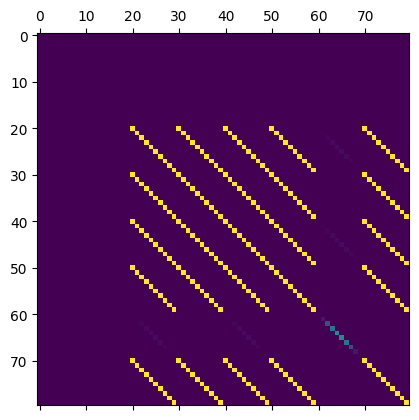

In [14]:
plt.matshow(np.abs(after_opt_thingy))